### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import energyflow as ef
from energyflow.archs.dnn import DNN

import importlib.util
import sys

sys.path.append('../OmniFold')
sys.path.append('../unfolding')

import ROOT
ROOT.gSystem.Load('../RooUnfold/build/libRooUnfold.so')

def import_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

omnifold_bdt = import_module_from_path("omnifold", "../unfolding/omnifold.py")
data_handler = import_module_from_path("data_handler", "../unfolding/data_handler.py")

omnifold_dnn = import_module_from_path("omnifold", "../OmniFold/omnifold.py")
modplot = import_module_from_path("modplot", "../OmniFold/modplot.py")
ibu = import_module_from_path("ibu", "../OmniFold/ibu.py")



2024-10-02 21:58:20.642957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 21:58:20.642995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 21:58:20.644184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 21:58:20.650630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/global/homes/t/trevin/miniconda3/e

### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# Settings

In [3]:
num_data = 10000
itnum = 3

In [4]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=num_data, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=num_data, exclude_keys=['particles'])}

synthetic, nature = datasets['Pythia26'], datasets['Herwig']

obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass', 'Jetpt']

In [5]:

print(synthetic.keys())
print(synthetic['gen_jets'].shape)
print(synthetic['gen_mults'].shape)


print(len(synthetic), len(nature))
print(synthetic['sim_jets'])


dict_keys(['gen_zgs', 'gen_sdms', 'gen_lhas', 'gen_mults', 'gen_tau2s', 'gen_jets', 'gen_widths', 'gen_ang2s', 'gen_Zs', 'sim_zgs', 'sim_sdms', 'sim_lhas', 'sim_mults', 'sim_tau2s', 'sim_jets', 'sim_widths', 'sim_ang2s'])
(10000, 4)
(10000,)
17 17
[[ 3.54686737e+02  1.76751902e+00  2.91190290e+00  2.56585560e+01]
 [ 1.10523918e+02  2.77768707e+00  4.74934799e+00  1.66694698e+01]
 [ 2.47493805e+02  1.85325375e-02  3.86815554e+00  1.41800489e+01]
 ...
 [ 1.42112503e+02 -1.28438302e+00  1.87526953e+00  2.05354538e+01]
 [ 2.19088043e+02 -9.06254346e-01  8.60003710e-01  8.84460163e+00]
 [ 2.70292114e+02 -4.38226783e-02  3.36260206e+00  5.34180975e+00]]


In [6]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, 
    ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

obs.setdefault('Jetpt', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,0],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 800), 'ylim': (0, 0.012),
    'xlabel': r'Jet_$pt$ [GeV]', 'symbol': r'$jet_pt$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
dnn_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
bdt_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:orange', 'zorder': 3}
bdt_binned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_unbinned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}

In [7]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():

    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass
Done with Jetpt


# Unbinned DNN Multifold

In [8]:
model_layer_sizes = [100, 100,] # [100,100,100] for max size

X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T


# set up the array of data/simulation detector-level observables
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'])), 
                                                np.zeros(len(obs['Mass']['simobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'])), 
                                                np.zeros(len(obs['Mass']['genobs'])))))

# standardize the inputs
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': './training/Step1_{}.weights.h5', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': './training/Step2_{}.weights.h5', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
#fitargs = {'batch_size': 500, 'epochs': 100, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

# apply the OmniFold procedure to get weights for the generation
multifold_ws_dnn = omnifold_dnn.omnifold(
    X_gen, Y_gen, 
    X_det, Y_det, 
    wdata, winit,
    (DNN, det_args), 
    (DNN, mc_args),
    fitargs, 
    val=0.2, 
    it=itnum,
    trw_ind=-2, 
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5340 - loss: 0.7636   
Epoch 1: val_loss improved from inf to 0.69421, saving model to ./training/Step1_0.weights.h5_Epoch-1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5343 - loss: 0.7623 - val_acc: 0.5537 - val_loss: 0.6942
Epoch 2/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6040 - loss: 0.6627
Epoch 2: val_loss improved from 0.69421 to 0.68563, saving model to ./training/Step1_0.weights.h5_Epoch-2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5613 - loss: 0.6868 - val_acc: 0.5608 - val_loss: 0.6856
Restoring model weights from the end of the best epoch: 2.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 480ms/step - acc: 0.4920 - loss: 1.0772
Epoch 1: val_loss improved from inf to 0.74248, saving model to ./training/Step2_0.weights.h5_Epoch-1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5001 - loss: 0.9117 - val_acc: 0.5000 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2


/home/trevin/miniconda3/envs/hepml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step - acc: 0.5720 - loss: 0.8274
Epoch 1: val_loss improved from inf to 0.94042, saving model to ./training/Step1_1.weights.h5_Epoch-1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5263 - loss: 31.9307 - val_acc: 0.5130 - val_loss: 0.9404
Epoch 2/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.5280 - loss: 0.8438
Epoch 2: val_loss did not improve from 0.94042
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5100 - loss: 294.3838 - val_acc: 0.5322 - val_loss: 0.9769
Restoring model weights from the end of the best epoch: 1.
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fc095413a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects inste

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 100)            │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,102 (43.37 KB)

 Trainable params: 11,102 (43.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step - acc: 0.5280 - loss: 0.8251
Epoch 1: val_loss improved from inf to 0.80323, saving model to ./training/Step1_2.weights.h5_Epoch-1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5363 - loss: 52364.6445 - val_acc: 0.5330 - val_loss: 0.8032
Epoch 2/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.5300 - loss: 0.8001
Epoch 2: val_loss improved from 0.80323 to 0.78060, saving model to ./training/Step1_2.weights.h5_Epoch-2.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5419 - loss: 6963.9429 - val_acc: 0.5400 - val_loss: 0.7806
Restoring model weights from the end of the best epoch: 2.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/2
 1/32 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - acc: 0.4840 - loss: 3203440.2500
Epoch 1: val_loss improved from inf to 0.65641, saving model to ./training/Step2_2.weights.h5_Epoch-1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.4988 - loss: 575635.6875 

I0000 00:00:1727928945.380905 3534374 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727928945.381140 3534374 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-02 21:15:45.396542: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Unbinned BDT Multifold

In [9]:

mc_entries = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries = np.asarray([(obs[obkey]['dataobs']) for obkey in obs_multifold]).T

pass_reco_mask = np.full(num_data, True)
pass_truth_mask = np.full(num_data, True)

In [10]:
multifold_ws_bdt, MC_test_bdt, _, _ = omnifold_bdt.unbinned_omnifold(
    mc_entries, 
    sim_entries, 
    measured_entries, 
    pass_reco_mask, 
    pass_truth_mask, 
    itnum
)

Starting iteration 0
Starting iteration 1
Starting iteration 2


# Unbinned BDT Singlefold

In [11]:
mc_data = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_data = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
meas_data = np.asarray([(obs[obkey]['dataobs']) for obkey in obs_multifold]).T
true_data = np.asarray([(obs[obkey]['truthobs']) for obkey in obs_multifold]).T

pass_reco_mask = np.full(num_data, True)
pass_truth_mask = np.full(num_data, True)

bdt_unbinned_single_results = []
for i in range(len(obs_multifold)):
    omnifold_weights, MC_test_bdt_single, _, _  = omnifold_bdt.unbinned_omnifold(mc_data[:,i], sim_data[:,i], meas_data[:,i], pass_reco_mask, pass_truth_mask, itnum)
    bdt_unbinned_single_results.append((omnifold_weights, MC_test_bdt_single))

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2


# Binned BDT Singlefold

In [12]:

sim_data_dict = {"mass": [], "width": [], "mult": [], "lnrho": [], "zgs": [], "tau21": [], 'jetpt': []}
mc_data_dict = {"mass": [], "width": [], "mult": [], "lnrho": [], "zgs": [], "tau21": [], 'jetpt': []}
meas_data_dict = {"mass": [], "width": [], "mult": [], "lnrho": [], "zgs": [], "tau21": [], 'jetpt': []}

# Populate the data lists from measured, simulated, and MC data
for i in range(len(meas_data)):
    meas_data_dict["mass"].append(meas_data[i][0])
    meas_data_dict["mult"].append(meas_data[i][1])
    meas_data_dict["width"].append(meas_data[i][2])
    meas_data_dict["tau21"].append(meas_data[i][3])
    meas_data_dict["zgs"].append(meas_data[i][4])
    meas_data_dict["lnrho"].append(meas_data[i][5])
    meas_data_dict['jetpt'].append(meas_data[i][6])

    mc_data_dict["mass"].append(mc_data[i][0])
    mc_data_dict["mult"].append(mc_data[i][1])
    mc_data_dict["width"].append(mc_data[i][2])
    mc_data_dict["tau21"].append(mc_data[i][3])
    mc_data_dict["zgs"].append(mc_data[i][4])
    mc_data_dict["lnrho"].append(mc_data[i][5])
    mc_data_dict['jetpt'].append(mc_data[i][6])

    sim_data_dict["mass"].append(sim_data[i][0])
    sim_data_dict["mult"].append(sim_data[i][1])
    sim_data_dict["width"].append(sim_data[i][2])
    sim_data_dict["tau21"].append(sim_data[i][3])
    sim_data_dict["zgs"].append(sim_data[i][4])
    sim_data_dict["lnrho"].append(sim_data[i][5])
    sim_data_dict['jetpt'].append(sim_data[i][6])


# Binned data parameters
bin_params = {
    "mass": obs["Mass"],
    "mult": obs["Mult"],
    "width": obs["Width"],
    "tau21": obs["Tau21"],
    "zgs": obs["zg"],
    "lnrho": obs["SDMass"],
    "jetpt": obs["Jetpt"]
}

# Create binned histograms and responses
binned_data = {}
for key, params in bin_params.items():
    binned_data[key] = {
        "hist": ROOT.TH1D(f"meas_{key}_hist", f"meas_{key}_hist", params["nbins_det"], params["xlim"][0], params["xlim"][1]),
        "response": ROOT.RooUnfoldResponse(params["nbins_det"], params["xlim"][0], params["xlim"][1], params["nbins_det"], params["xlim"][0], params["xlim"][1])
    }

# Fill response matrices and histograms
def build_data(response, mc_list, sim_list, measured_list, measured_hist):
    for MC, sim, measured in zip(mc_list, sim_list, measured_list):
        response.Fill(sim, MC)
        measured_hist.Fill(measured)
    return response, measured_hist

for key in binned_data:
    binned_data[key]["response"], binned_data[key]["hist"] = build_data(
        binned_data[key]["response"], mc_data_dict[key], sim_data_dict[key], meas_data_dict[key], binned_data[key]["hist"]
    )
 
# Run binned OmniFold
bdt_binned_single_results = []
for key in binned_data:
    response = binned_data[key]["response"]
    hist = binned_data[key]["hist"]
    omnifold_weights, mc_test, _, _ = omnifold_bdt.binned_omnifold(response, hist, itnum)
    bdt_binned_single_results.append((omnifold_weights, mc_test))


Starting iteration 0


Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2


In [13]:
import pickle
import gzip


# Combine the variables into a dictionary to save them in a single pickle file
data_to_save = {
    "bdt_binned_single_results": bdt_binned_single_results,
    "bdt_unbinned_single_results": bdt_unbinned_single_results,
    "multifold_ws_bdt": multifold_ws_bdt,
    "MC_test_bdt": MC_test_bdt,
    "multifold_ws_dnn": multifold_ws_dnn
}

# Saving the combined data as a compressed pickle.gz file
output_file = './saved_weights.pickle.gz'

with gzip.open(output_file, 'wb') as f:
    pickle.dump(data_to_save, f)

output_file


'./saved_weights.pickle.gz'

# PLOTTING


In [14]:
# Loading the data again and destructuring it from the dictionary
with gzip.open('./saved_weights.pickle.gz', 'rb') as f:
    loaded_data = pickle.load(f)

# Destructuring the variables
bdt_binned_single_results = loaded_data['bdt_binned_single_results']
bdt_unbinned_single_results = loaded_data['bdt_unbinned_single_results']
multifold_ws_bdt, MC_test_bdt  = loaded_data['multifold_ws_bdt'], loaded_data['MC_test_bdt']
multifold_ws_dnn = loaded_data['multifold_ws_dnn']


## SETTINGS

In [15]:
data = True
sim = True
mc = True
truth = True

ibu = True
dnn_unbinned_multi = True
bdt_unbinned_multi = True
bdt_binned_single = True
bdt_unbinned_single = True

truth_fill = True
ibu_err = True
dnn_unbinned_multi_err = True
bdt_unbinned_multi_err = True
bdt_binned_single_err = True
bdt_unbinned_single_err = True

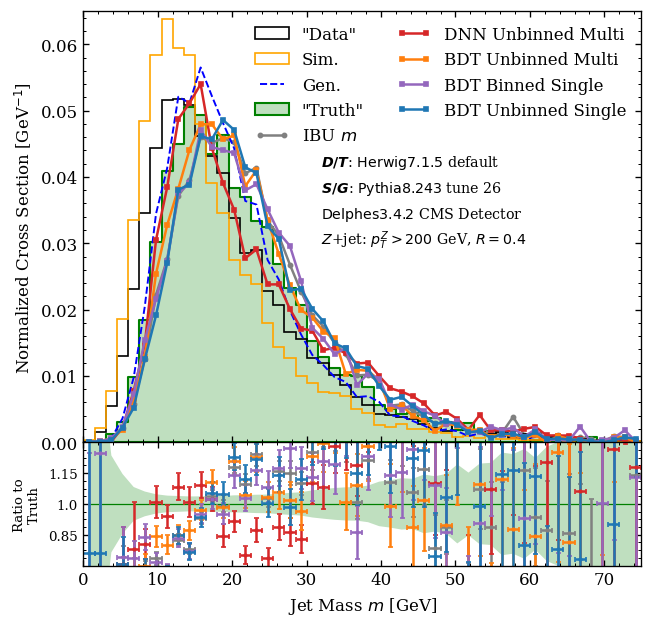

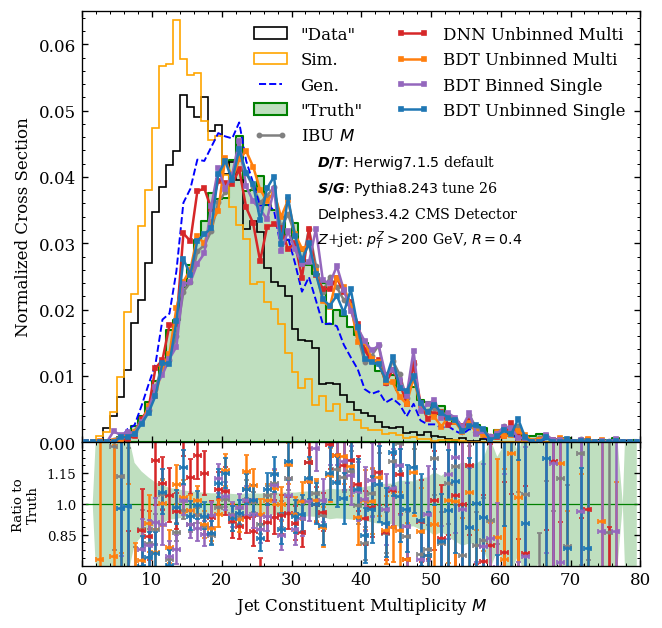

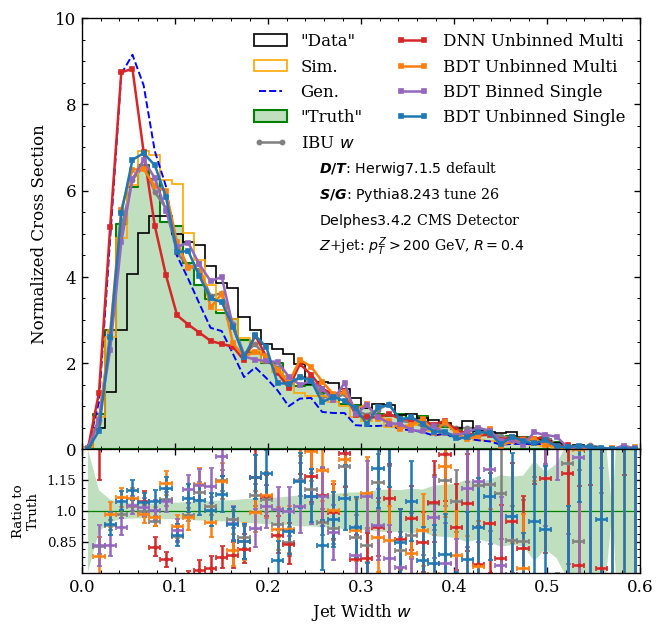

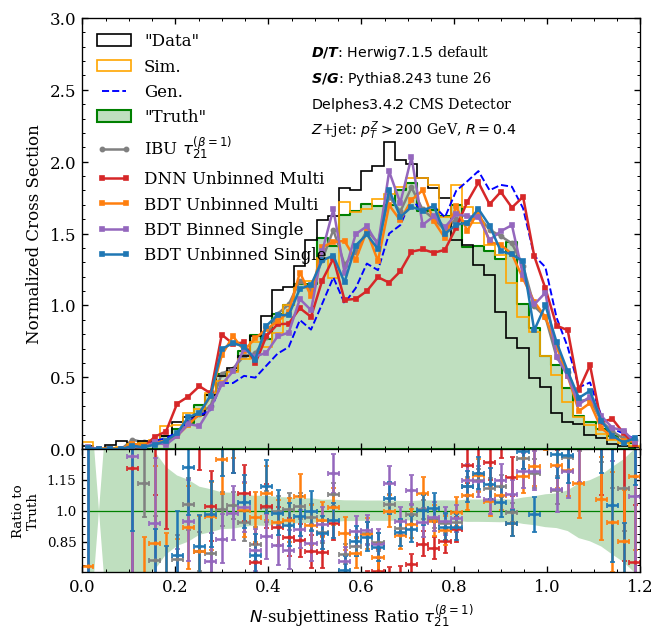

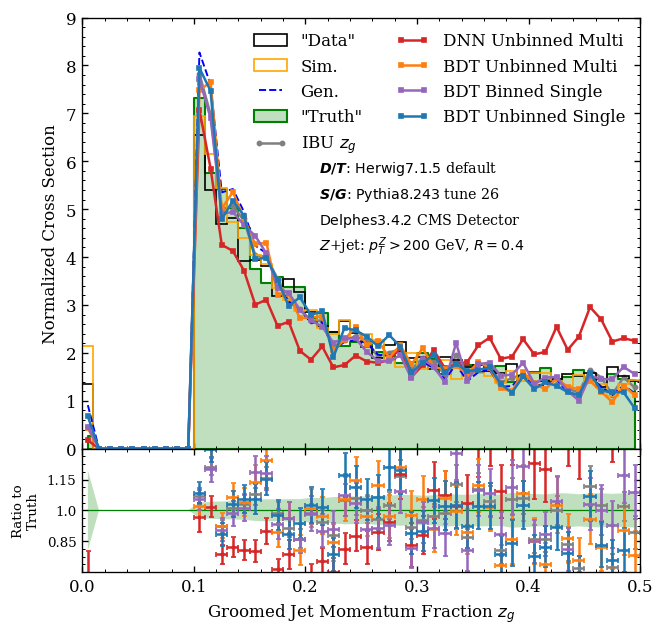

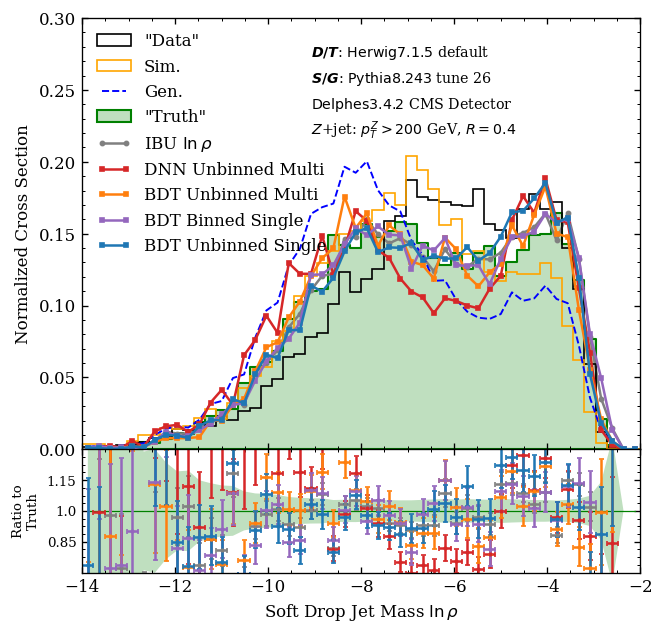

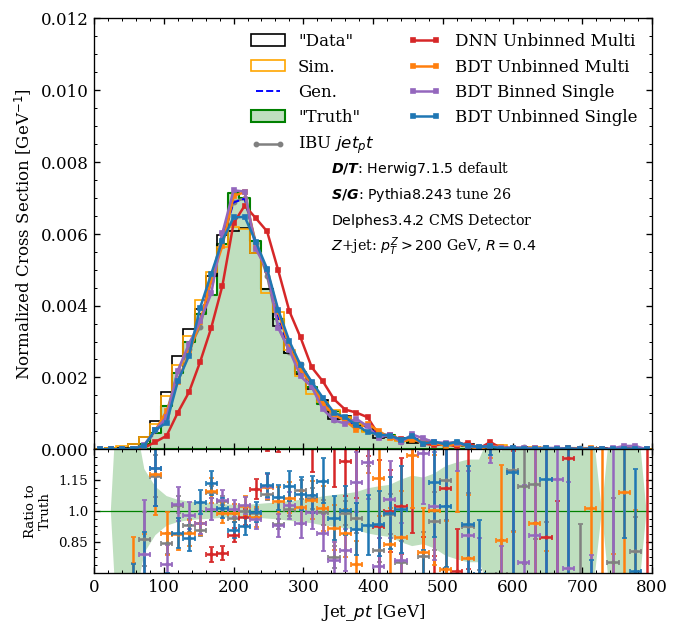

In [16]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    if data: 
        ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='"Data"', **hist_style)
    if sim:
        ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    if mc:
        ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    if truth:
        ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    if ibu:
        ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    ob['histgen_dnn_unbinned_multi'], ob['histgen_unc_dnn_unbinned_multi'] = modplot.calc_hist(
        ob['genobs'], 
        weights=multifold_ws_dnn[2*itnum], 
        bins=ob['bins_mc'], 
        density=True
    )[:2]

    ob['histgen_bdt_unbinned_multi'], ob['histgen_unc_bdt_unbinned_multi'] = modplot.calc_hist(
        MC_test_bdt[:,i], 
        weights=multifold_ws_bdt[-1][1],        
        bins=ob['bins_mc'], 
        density=True
    )[:2]

    ob['histgen_bdt_binned_single'], ob['histgen_unc_bdt_binned_single'] = modplot.calc_hist(
        bdt_binned_single_results[i][1].flatten(), 
        weights=bdt_binned_single_results[i][0][-1][1], 
        bins=ob['bins_mc'], 
        density=True
    )[:2]

    ob['histgen_bdt_unbinned_single'], ob['histgen_unc_bdt_unbinned_single'] = modplot.calc_hist(
        bdt_unbinned_single_results[i][1].flatten(), 
        weights=bdt_unbinned_single_results[i][0][-1][1], 
        bins=ob['bins_mc'], 
        density=True
    )[:2]
    
    if dnn_unbinned_multi:
        ax0.plot(ob['midbins_mc'], ob['histgen_dnn_unbinned_multi'], **dnn_unbinned_multi_style, label='DNN Unbinned Multi')
    if bdt_unbinned_multi:
        ax0.plot(ob['midbins_mc'], ob['histgen_bdt_unbinned_multi'], **bdt_unbinned_multi_style, label='BDT Unbinned Multi')
    if bdt_binned_single:
        ax0.plot(ob['midbins_mc'], ob['histgen_bdt_binned_single'], **bdt_binned_single_style, label='BDT Binned Single')
    if bdt_unbinned_single:
        ax0.plot(ob['midbins_mc'], ob['histgen_bdt_unbinned_single'], **bdt_unbinned_single_style, label='BDT Unbinned Single')


    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)

    of_ratio_dnn_unbinned_multi = ob['histgen_dnn_unbinned_multi'] /(ob['truth_hist'] + 10**-50)
    of_ratio_bdt_unbinned_multi = ob['histgen_bdt_unbinned_multi'] /(ob['truth_hist'] + 10**-50)
    of_ratio_bdt_binned_single = ob['histgen_bdt_binned_single'] /(ob['truth_hist'] + 10**-50)
    of_ratio_bdt_unbinned_single = ob['histgen_bdt_unbinned_single'] /(ob['truth_hist'] + 10**-50)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc'] / (ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc'] / (ob['truth_hist'] + 10**-50)

    of_unc_ratio_dnn_unbinned_multi = ob['histgen_unc_dnn_unbinned_multi'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_bdt_unbinned_multi = ob['histgen_unc_bdt_unbinned_multi'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_bdt_binned_single = ob['histgen_unc_bdt_binned_single'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_bdt_unbinned_single = ob['histgen_unc_bdt_unbinned_single'] / (ob['truth_hist'] + 10**-50)

    if truth_fill:
        ax1.fill_between(
            ob['midbins_mc'], 
            1 - truth_unc_ratio, 
            1 + truth_unc_ratio,          
            facecolor=truth_style['facecolor'], 
            zorder=-2
        )
    
    if ibu_err:
        ax1.errorbar(
            ob['midbins_mc'], 
            ibu_ratio, 
            xerr=ob['binwidth_mc']/2, 
            yerr=ibu_unc_ratio,                       
            color=ibu_style['color'], 
            **modplot.style('errorbar')
        ) # IBU Error Bar

    if dnn_unbinned_multi_err:
        ax1.errorbar(
            ob['midbins_mc'],
            of_ratio_dnn_unbinned_multi,
            xerr=ob['binwidth_mc']/2,
            yerr=of_unc_ratio_dnn_unbinned_multi,
            color=dnn_unbinned_multi_style['color'],  # Added comma here
            **modplot.style('errorbar')
        ) # DNN Error Bar

    if bdt_unbinned_multi_err:
        ax1.errorbar(
            ob['midbins_mc'], 
            of_ratio_bdt_unbinned_multi, 
            xerr=ob['binwidth_mc']/2, 
            yerr=of_unc_ratio_bdt_unbinned_multi, 
            color=bdt_unbinned_multi_style['color'], 
            **modplot.style('errorbar')
        )

    if bdt_binned_single_err:    
        ax1.errorbar(
            ob['midbins_mc'], 
            of_ratio_bdt_binned_single, 
            xerr=ob['binwidth_mc']/2, 
            yerr=of_unc_ratio_bdt_binned_single, 
            color=bdt_binned_single_style['color'], 
            **modplot.style('errorbar')
        ) # Binned Error Bar

    if bdt_unbinned_single_err:
        ax1.errorbar(
            ob['midbins_mc'], 
            of_ratio_bdt_unbinned_single, 
            xerr=ob['binwidth_mc']/2, 
            yerr=of_unc_ratio_bdt_unbinned_single, 
            color=bdt_unbinned_single_style['color'], 
            **modplot.style('errorbar')
        ) # Unbinned Error Bar


    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\boldsymbol{D/T}$: $\mathsf{Herwig 7.1.5}$ default',
                  line_1=r'$\boldsymbol{S/G}$: $\mathsf{Pythia 8.243}$ tune 26',
                  line_2=r'$\mathsf{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig(f'plots/BDT_OmniFold_{obkey}.png', bbox_inches='tight')
    plt.show()

# Computing Triangular Discriminator

In [17]:
def triangular_discriminator(p, q):
    p = np.array(p)
    q = np.array(q)
    if len(p) != len(q):
        print("Error: The distributions 'p' and 'q' must have the same length.")
        return None
    
    epsilon = 1e-50
    discriminator = np.sum((p - q)**2 / (p + q + epsilon))
    return 0.5 * discriminator


In [18]:
triangular_discriminator_results = {}

# Iterate through each observable in obs.items()
for obkey, ob in obs.items():
    if 'truth_hist' in ob:
        truth_hist = ob['truth_hist']
        # Dictionary to store triangular discriminator values for this observable
        discriminator_values = {
            'dnn_unbinned_multi': triangular_discriminator(ob['histgen_dnn_unbinned_multi'], truth_hist),
            'bdt_unbinned_multi': triangular_discriminator(ob['histgen_bdt_unbinned_multi'], truth_hist),
            'bdt_binned_single': triangular_discriminator(ob['histgen_bdt_binned_single'], truth_hist),
            'bdt_unbinned_single': triangular_discriminator(ob['histgen_bdt_unbinned_single'], truth_hist),
            'ibu': triangular_discriminator(ob['ibu_phis'][itnum], truth_hist),
            'data': triangular_discriminator(ob['data_hist'], truth_hist),
            'gen': triangular_discriminator(ob['genobs_hist'], truth_hist)
        }
        
        # Add the results for this observable (obkey) to the main results dictionary
        triangular_discriminator_results[obkey] = discriminator_values

# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame(triangular_discriminator_results)

# Display the DataFrame
df_results

    



,Mass,Mult,Width,Tau21,zg,SDMass,Jetpt
dnn_unbinned_multi,0.008240,0.009337,2.190729,1.204642,2.017086,0.058036,0.001841
bdt_unbinned_multi,0.006644,0.005872,0.595412,0.221244,0.582424,0.020857,0.000202
bdt_binned_single,0.009093,0.009477,0.575459,0.347902,0.435865,0.022853,0.000273
bdt_unbinned_single,0.010377,0.007669,0.521365,0.323818,0.653031,0.021459,0.000310
ibu,0.008962,0.006123,0.310900,0.235782,0.337198,0.017834,0.000171
data,0.017913,0.131466,1.543335,0.574349,0.636106,0.061706,0.000408
gen,0.004874,0.019917,2.421490,1.029539,0.683152,0.098851,0.000161
